In [14]:
from sklearn.preprocessing import OneHotEncoder,RobustScaler
from sklearn.compose import ColumnTransformer 
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, precision_score, recall_score ,classification_report,confusion_matrix

from collections import defaultdict
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

from modelzoo import *

1. 전처리된 df → 시계열 형태로 정렬
2. Sliding Window 등으로 (samples, timesteps, features) 구성
3. MinMaxScaler로 시퀀스 스케일링
4. LSTM 모델 설계 (Keras 기반 추천)
5. 학습 및 예측
6. 분류/회귀 성능 비교
7. 베이스라인보다 나은지 분석


In [16]:
# 2단계 전처리
df = pd.read_csv('../data/csv/50area_dummy_processed.csv')
df_sort = df.sort_values(by=['station_location','connection_start_time_ts'])
df_sort

,last_charge_end_time_ts,connection_start_time_ts,charging_start_time_ts,charging_start_time_missing,charging_end_time_ts,charging_end_time_missing,connection_end_time_ts,expected_departure_time_ts,expected_departure_time_missing,idle_time_ts,...,kwh_per_usage_time_missing,station_location,evse_name,evse_type,supports_discharge,scheduled_charge,weekday,usage_departure_range,post_charge_departure_range,cluster
1076,1572566400,1572616980,1572618600,False,1572620220,False,1572627741,1572621900,False,50580,...,False,st-00,st-00_evse-01,FC,n,n,4,4,4,0
0,1572566400,1572741120,1572741360,False,1572742200,False,1572742822,1572742500,False,174720,...,False,st-00,st-00_evse-00,FC,n,n,6,2,1,0
1077,1572627741,1572864741,1572866181,False,1572867321,False,1572869057,1572868041,False,237000,...,False,st-00,st-00_evse-01,FC,n,n,0,3,2,0
1078,1572869057,1572995177,1572995777,False,1572997757,False,1573000363,1573001717,False,126120,...,False,st-00,st-00_evse-01,FC,n,n,1,1,2,0
1,1572742822,1573022962,1573024402,False,1573025122,False,1573028631,1573028062,False,280140,...,False,st-00,st-00_evse-00,FC,n,y,2,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209502,1735255426,1735524526,1735525666,False,1735531246,False,1735532087,1735531846,False,269100,...,False,st-49,st-49_evse-01,SC,y,y,0,2,1,0
210413,1735413107,1735550927,1735551647,False,1735552427,False,1735556327,0,True,137820,...,False,st-49,st-49_evse-02,FC,n,y,0,2,3,1
209503,1735532087,1735621667,1735623467,False,1735634267,False,1735636898,1735633787,False,89580,...,False,st-49,st-49_evse-01,SC,y,y,1,4,2,0
212525,1735339994,1735623254,1735624334,False,1735625774,False,1735627862,1735626434,False,283260,...,False,st-49,st-49_evse-04,FC,n,n,1,3,2,0


In [17]:
df

,last_charge_end_time_ts,connection_start_time_ts,charging_start_time_ts,charging_start_time_missing,charging_end_time_ts,charging_end_time_missing,connection_end_time_ts,expected_departure_time_ts,expected_departure_time_missing,idle_time_ts,...,kwh_per_usage_time_missing,station_location,evse_name,evse_type,supports_discharge,scheduled_charge,weekday,usage_departure_range,post_charge_departure_range,cluster
0,1572566400,1572741120,1572741360,False,1572742200,False,1572742822,1572742500,False,174720,...,False,st-00,st-00_evse-00,FC,n,n,6,2,1,0
1,1572742822,1573022962,1573024402,False,1573025122,False,1573028631,1573028062,False,280140,...,False,st-00,st-00_evse-00,FC,n,y,2,2,3,0
2,1573028631,1573151511,1573152531,False,1573153311,False,1573154025,1573154631,False,122880,...,False,st-00,st-00_evse-00,FC,n,n,3,2,1,0
3,1573154025,1573424925,1573425285,False,1573426245,False,1573427221,1573426785,False,270900,...,False,st-00,st-00_evse-00,FC,n,y,6,2,1,0
4,1573427221,1573555441,1573556341,False,1573557481,False,1573559761,1573558201,False,128220,...,False,st-00,st-00_evse-00,FC,n,y,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212521,1734541321,1734749281,1734750061,False,1734751261,False,1734753549,1734750601,False,207960,...,False,st-49,st-49_evse-04,FC,n,y,5,3,2,0
212522,1734753549,1735031349,1735031409,False,1735032129,False,1735037217,1735031589,False,277800,...,False,st-49,st-49_evse-04,FC,n,y,1,4,3,0
212523,1735037217,1735305177,1735305897,False,1735306677,False,1735307216,1735308417,False,267960,...,False,st-49,st-49_evse-04,FC,n,n,4,1,1,0
212524,1735307216,1735335116,1735335596,False,1735336976,False,1735339994,1735336496,False,27900,...,False,st-49,st-49_evse-04,FC,n,n,4,4,2,0


In [ ]:
target_class = 'post_charge_departure_range'
target_reg = 'kwh_per_usage_time'
# sort colums
onehot_col = ['station_location','evse_name','evse_type','supports_discharge','scheduled_charge','weekday','cluster','post_charge_departure_range','usage_departure_range'] 
scale_col = [col for col in df.columns.to_list() if col not in onehot_col]

ct = ColumnTransformer(
    [
        ('scaling',RobustScaler(),scale_col),
        ('onehot',OneHotEncoder(sparse_output=False,handle_unknown='ignore'),onehot_col)
    ]
)

data = ct.fit_transform(df)
df_processed = pd.DataFrame(data,columns=ct.get_feature_names_out())
df_processed

,scaling__last_charge_end_time_ts,scaling__connection_start_time_ts,scaling__charging_start_time_ts,scaling__charging_start_time_missing,scaling__charging_end_time_ts,scaling__charging_end_time_missing,scaling__connection_end_time_ts,scaling__expected_departure_time_ts,scaling__expected_departure_time_missing,scaling__idle_time_ts,...,onehot__post_charge_departure_range_1,onehot__post_charge_departure_range_2,onehot__post_charge_departure_range_3,onehot__post_charge_departure_range_4,onehot__post_charge_departure_range_5,onehot__usage_departure_range_1,onehot__usage_departure_range_2,onehot__usage_departure_range_3,onehot__usage_departure_range_4,onehot__usage_departure_range_5
0,-0.996249,-0.995926,-0.979866,0.0,-0.979958,0.0,-0.996078,-0.681354,0.0,0.283768,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.994089,-0.992476,-0.976429,0.0,-0.976522,0.0,-0.992579,-0.678409,0.0,0.987976,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.990591,-0.990903,-0.974873,0.0,-0.974966,0.0,-0.991044,-0.677104,0.0,-0.062525,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.989056,-0.987556,-0.971561,0.0,-0.971651,0.0,-0.987700,-0.674298,0.0,0.926253,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.985712,-0.985958,-0.969969,0.0,-0.970057,0.0,-0.986077,-0.672942,0.0,-0.026854,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212521,0.986378,0.987225,0.987538,0.0,0.987540,0.0,0.987212,0.989270,0.0,0.505812,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
212522,0.988976,0.990678,0.990955,0.0,0.990951,0.0,0.990684,0.992168,0.0,0.972345,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
212523,0.992448,0.994030,0.994288,0.0,0.994285,0.0,0.993990,0.995022,0.0,0.906613,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
212524,0.995753,0.994396,0.994649,0.0,0.994653,0.0,0.994391,0.995312,0.0,-0.696994,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
#지점별로 시퀀스 분리
seq_len = 10 
max_n = 1*24 # 최대 예측 n (1주일)

def create_seq(df, data_scaled, seq_len,max_n):
    x_seq,y_class,y_reg = [],[],[]
    for i in range(len(df)-seq_len):
        

In [ ]:
#3단계: LSTM 멀티태스크 모델 구성 (회귀 + 분류)
#모델1

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight  # 클래스 가중치 (불균형 대응)

    def forward(self, input, target):
        logp = F.log_softmax(input, dim=1)
        p = torch.exp(logp)
        logp = (1 - p) ** self.gamma * logp
        loss = F.nll_loss(logp, target, weight=self.weight)
        return loss 

class MultiTargetDataset(Dataset):
    def __init__(self,x,n,y_regs,y_clss):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.n = torch.tensor(n,dtype=torch.float32)
        self.y_reg = torch.tensor(y_regs,dtype=torch.float32)
        self.y_cls =torch.tensor(y_clss,dtype=torch.long)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx],self.n[idx],self.y_reg[idx],self.y_cls[idx]

#data
X,n_array,y_regs,y_clss = create_seq(df,data_scaled,seq_len,max_n)

#hyper parameter
input_dim = X.shape[2]
hidden_dim = 128
num_layers = 2
num_classes = len(np.unique(y_clss))
batch_size = 64
epochs = 10
lr = 0.01
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = LSTMwithMultiOutput(input_dim,hidden_dim,num_layers,num_classes).to(device)
# model = BiLSTMwithMultiOutput(input_dim,hidden_dim,num_layers,num_classes).to(device)
dataset = MultiTargetDataset(X,n_array,y_regs,y_clss)
loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)


unique_classes = np.unique(y_clss)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_clss)
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)


loss_fn_reg = nn.MSELoss()
# loss_fn_cls = nn.CrossEntropyLoss(weight=weights_tensor)
loss_fn_cls = FocalLoss(gamma=2.0,weight=weights_tensor)

optimizer = optim.Adam(model.parameters(),lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)




In [125]:
from collections import Counter
print(Counter(y_clss))


Counter({0.0: 413967, 2.0: 285602, 1.0: 17983})


In [120]:
for epoch in range(epochs):
    model.train()
    total_loss, total_reg_loss, total_cls_loss = 0, 0, 0
    all_preds, all_labels = [], []

    for xb, nb, yb_reg, yb_cls in loader:
        xb, nb = xb.to(device), nb.to(device)
        yb_reg, yb_cls = yb_reg.to(device), yb_cls.to(device)

        pred_reg, pred_cls = model(xb, nb)  # 회귀, 분류 예측값
        # print(yb_reg.min().item(), yb_reg.max().item())  # 정규화된 범위인지
        # print(pred_reg.min().item(), pred_reg.max().item())  # 튀는 값 있는지
        # print(pred_reg.shape, yb_reg.shape)

        # 손실 계산
        loss_reg = loss_fn_reg(pred_reg, yb_reg)
        loss_cls = loss_fn_cls(pred_cls, yb_cls)
        
        alpha = 1.0  # 회귀 손실 비중
        beta = 2.0   # 분류 손실 비중 (더 작게 시작)

        loss = alpha * loss_reg + beta * loss_cls

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

        optimizer.step()

        total_loss += loss.item()
        total_reg_loss += loss_reg.item()
        total_cls_loss += loss_cls.item()

        # 분류 정확도 계산
        all_preds.extend(pred_cls.argmax(dim=1).cpu().numpy())
        all_labels.extend(yb_cls.cpu().numpy())
        

    n_batches = len(loader)
        
    scheduler.step()
    curr_lr = optimizer.param_groups[0]['lr']

    avg_loss = total_loss / n_batches
    avg_reg  = total_reg_loss  / n_batches
    avg_cls  = total_cls_loss  / n_batches
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')       # 다중 클래스용
    precision = precision_score(all_labels, all_preds, average='macro',zero_division=1)
    recall = recall_score(all_labels, all_preds, average='macro')
    print(f"[{epoch+1}] LR = {curr_lr:.5f} Loss: {avg_loss:.4f} | Reg: {avg_reg:.4f} | Cls: {avg_cls:.4f} | Acc: {acc:.4f} | F1: {f1:.4f} | precision: {precision:.4f} | recall: {recall:.4f}")

[1] LR = 0.01000 Loss: 1.0031 | Reg: 0.0153 | Cls: 0.4939 | Acc: 0.4220 | F1: 0.3159 | precision: 0.3337 | recall: 0.3338
[2] LR = 0.01000 Loss: 0.9953 | Reg: 0.0143 | Cls: 0.4905 | Acc: 0.4284 | F1: 0.3179 | precision: 0.3331 | recall: 0.3323
[3] LR = 0.00500 Loss: 0.9957 | Reg: 0.0144 | Cls: 0.4907 | Acc: 0.4308 | F1: 0.3184 | precision: 0.3330 | recall: 0.3316
[4] LR = 0.00500 Loss: 0.9897 | Reg: 0.0142 | Cls: 0.4878 | Acc: 0.4601 | F1: 0.3292 | precision: 0.3342 | recall: 0.3347
[5] LR = 0.00500 Loss: 0.9898 | Reg: 0.0142 | Cls: 0.4878 | Acc: 0.4697 | F1: 0.3303 | precision: 0.3329 | recall: 0.3327
[6] LR = 0.00250 Loss: 0.9898 | Reg: 0.0142 | Cls: 0.4878 | Acc: 0.4668 | F1: 0.3296 | precision: 0.3327 | recall: 0.3326
[7] LR = 0.00250 Loss: 0.9873 | Reg: 0.0141 | Cls: 0.4866 | Acc: 0.4919 | F1: 0.3313 | precision: 0.3324 | recall: 0.3329
[8] LR = 0.00250 Loss: 0.9877 | Reg: 0.0141 | Cls: 0.4868 | Acc: 0.4835 | F1: 0.3318 | precision: 0.3330 | recall: 0.3330
[9] LR = 0.00125 Loss: 0

In [121]:
# 예측 → 정수 클래스 → 문자열로 디코딩
model.eval()  # <--- Add this line to set model to eval mode
with torch.no_grad():
    x_sample = X[0]                # shape: (seq_len, input_dim)
    n_sample = n_array[0]
    x_tensor = torch.tensor(x_sample, dtype=torch.float32).unsqueeze(0).to(device)
    n_tensor = torch.tensor(n_sample, dtype=torch.float32).unsqueeze(0).to(device)

    pred_energy, pred_state = model(x_tensor, n_tensor)
    pred_state_label = target_cls_le.inverse_transform([int(pred_state.argmax(1).item())])[0]
    real_state_label = target_cls_le.inverse_transform([int(y_clss[0])])[0]
    pred_energy_cpu = pred_energy.detach().cpu().numpy().reshape(-1, 1)
    pred_energy_inv = scaler_y.inverse_transform(pred_energy_cpu)
print(f"예측 장비 상태: {pred_state_label}, 실제 상태: {real_state_label}")
print(f"예측 에너지 사용량 (역정규화값): {pred_energy_inv.item():.4f}")

예측 장비 상태: 정상, 실제 상태: 경고
예측 에너지 사용량 (역정규화값): 16.0599


In [129]:
#모델 저장
# torch.save(model,'../model/bilstm_0.48.pt')
bilstms = torch.load('../model/bilstm_0.48.pt', weights_only=False)

In [143]:
#입력 n 시간뒤 예측
sample_seq = X[10000]
sample_seq_tensor = torch.tensor(sample_seq,dtype=torch.float32).unsqueeze(0).to(device)

def predict_n_hours_ahead(n_hour, model):
    n_norm = n_hour / max_n
    n_tensor = torch.tensor([[n_norm]], dtype=torch.float32).to(device)  # shape (1, 1)
    
    with torch.no_grad():
        model.eval()
        pred_reg, pred_cls = model(sample_seq_tensor, n_tensor)
        pred_energy = scaler_y.inverse_transform(pred_reg.cpu().numpy().reshape(-1, 1))[0][0]
        pred_cls_label = target_cls_le.inverse_transform([torch.argmax(pred_cls, dim=1).item()])[0]
    return pred_energy, pred_cls_label

n = 3 # 12시간 뒤 예측
에너지, 상태 = predict_n_hours_ahead(n,bilstms)
print(f"{n}시간 뒤 에너지 사용량: {에너지:.2f}, 장비 상태: {상태}")

3시간 뒤 에너지 사용량: 16.07, 장비 상태: 정상


c:\ProgramData\Miniconda3\envs\mainproject\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Miniconda3\envs\mainproject\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Miniconda3\envs\mainproject\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Miniconda3\envs\mainproject\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54744 (\N{HANGUL SYLLABLE HEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Miniconda3\envs\mainproject\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 

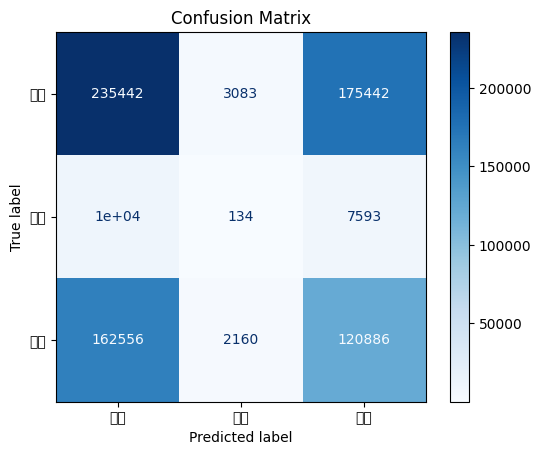

In [122]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_cls_le.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [101]:
print("Class별 F1:", f1_score(all_labels, all_preds, average=None))

Class별 F1: [3.71370370e-01 2.36239074e-04 6.24669214e-01]


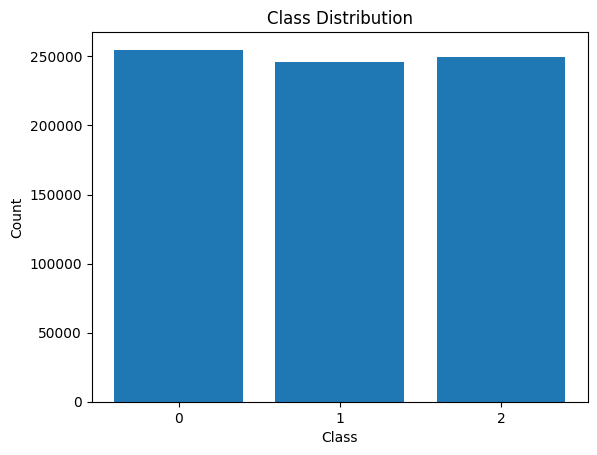

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_clss, bins=np.arange(num_classes+1)-0.5, rwidth=0.8)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(range(num_classes))
plt.show()
